<a href="https://colab.research.google.com/github/tanvir-152/Thesis_Codes/blob/main/FuNet_A_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   For Indian Pines
*   Addition Fusion Model of Base Paper

  OA:  0.7959

  AA: 0.8857  
  
  K: 0.7684

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/thesis_code

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/thesis_code


In [ ]:
!pip install -U gast==0.2.2
!pip install tensorflow==1.14
!pip install tensorflow-determinism

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def confusion_mat(x_out, y_in):
  x_cls = tf.transpose(x_out)
  y_cls = tf.transpose(y_in)
  x_cls = tf.argmax(x_out, 1)
  # x_cls = tf.nn.embedding_lookup(np.identity(16), x_cls_)
  # x_cls = convert_to_one_hot(np.array(x_cls)-1, 16)
# TrLabel = TrLabel.T
  y_cls = tf.argmax(y_in, 1)
  confusion = tf.confusion_matrix(y_cls, x_cls, 16)
  return x_cls, y_cls, confusion

In [ ]:

"""
@author: danfeng
"""
#import library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io as scio
import scipy.io as sio
from tf_utils import random_mini_batches_GCN1, convert_to_one_hot
from tensorflow.python.framework import ops
from tfdeterminism import patch
patch()

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def create_placeholders(n_x, n_x1, n_y):

    isTraining = tf.placeholder_with_default(True, shape=())
    x_in = tf.placeholder(tf.float32,  [None, n_x], name = "x_in")
    x_in1 = tf.placeholder(tf.float32,  [None, n_x1], name = "x_in1")
    y_in = tf.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap_train = tf.placeholder(tf.float32, [None, None], name = "lap_train")

    return x_in, x_in1, y_in, lap_train, isTraining

def initialize_parameters():

    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [200,128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())

    x_jw1 = tf.get_variable("x_jw1", [128,128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_jb1 = tf.get_variable("x_jb1", [128], initializer = tf.zeros_initializer())

    x_jw2 = tf.get_variable("x_jw2", [128,16], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_jb2 = tf.get_variable("x_jb2", [16], initializer = tf.zeros_initializer())

    x_conv_w1 = tf.get_variable("x_conv_w1", [3,3,200,32], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_conv_b1 = tf.get_variable("x_conv_b1", [32], initializer = tf.zeros_initializer())

    x_conv_w2 = tf.get_variable("x_conv_w2", [3,3,32,64], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_conv_b2 = tf.get_variable("x_conv_b2", [64], initializer = tf.zeros_initializer())

    x_conv_w3 = tf.get_variable("x_conv_w3", [1,1,64,128], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    x_conv_b3 = tf.get_variable("x_conv_b3", [128], initializer = tf.zeros_initializer())

    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_jw1": x_jw1,
                  "x_jb1": x_jb1,
                  "x_jw2": x_jw2,
                  "x_jb2": x_jb2,
                  "x_conv_w1": x_conv_w1,
                  "x_conv_b1": x_conv_b1,
                  "x_conv_w2": x_conv_w2,
                  "x_conv_b2": x_conv_b2,
                  "x_conv_w3": x_conv_w3,
                  "x_conv_b3": x_conv_b3}

    return parameters

def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)

    return x_out

def mynetwork(x, x1, parameters, Lap, isTraining, momentums = 0.9):

    x1 = tf.reshape(x1, [-1, 7, 7, 200], name = "x1")

    with tf.name_scope("x_layer_1"):

         x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)
         x_a1 = tf.nn.relu(x_z1_bn)

         x_conv_z1 = tf.nn.conv2d(x1, parameters['x_conv_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b1']
         x_conv_z1_bn = tf.layers.batch_normalization(x_conv_z1, momentum = momentums, training = isTraining)
         x_conv_z1_po = tf.layers.max_pooling2d(x_conv_z1_bn, 2, 2, padding='SAME')
         x_conv_a1 = tf.nn.relu(x_conv_z1_po)

    with tf.name_scope("x_layer_2"):

         x_conv_z2 = tf.nn.conv2d(x_conv_a1, parameters['x_conv_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b2']
         x_conv_z2_bn = tf.layers.batch_normalization(x_conv_z2, momentum = momentums, training = isTraining)
         x_conv_z2_po = tf.layers.max_pooling2d(x_conv_z2_bn, 2, 2, padding='SAME')
         x_conv_a2 = tf.nn.relu(x_conv_z2_po)

    with tf.name_scope("x_layer_3"):

         x_conv_z3 = tf.nn.conv2d(x_conv_a2, parameters['x_conv_w3'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_conv_b3']
         x_conv_z3_bn = tf.layers.batch_normalization(x_conv_z3, momentum = momentums, training = isTraining)
         x_conv_z3_po = tf.layers.max_pooling2d(x_conv_z3_bn, 2, 2, padding='SAME')
         x_conv_a3 = tf.nn.relu(x_conv_z3_po)

         x_conv_a3_shape = x_conv_a3.get_shape().as_list()
         x_conv_z3_2d = tf.reshape(x_conv_a3, [-1, x_conv_a3_shape[1] * x_conv_a3_shape[2] * x_conv_a3_shape[3]])

         joint_encoder_layer = x_a1 + x_conv_z3_2d

    with tf.name_scope("x_joint_layer_1"):

         x_zj1 = tf.matmul(joint_encoder_layer, parameters['x_jw1']) + parameters['x_jb1']
         x_zj1_bn = tf.layers.batch_normalization(x_zj1, momentum = momentums, training = isTraining)
         x_aj1 = tf.nn.relu(x_zj1_bn)

    with tf.name_scope("x_layer_4"):
         x_zj2 = tf.matmul(x_aj1, parameters['x_jw2']) + parameters['x_jb2']

    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_jw1']) + tf.nn.l2_loss(parameters['x_jw2'])\
               + tf.nn.l2_loss(parameters['x_conv_w1']) + tf.nn.l2_loss(parameters['x_conv_w2'])  + tf.nn.l2_loss(parameters['x_conv_w3'])

    return x_zj2, l2_loss

def mynetwork_optimaization(y_est, y_re, l2_loss, reg, learning_rate, global_step):

    y_re = tf.squeeze(y_re, name = 'y_re')

    with tf.name_scope("cost"):
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss

    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])

    return cost, optimizer

def train_mynetwork(x_train, x_test, train_x, test_x, y_train, y_test, L_train, L_test, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 1
    (m, n_x) = x_train.shape
    (m, n_y) = y_train.shape
    (m, n_x1) = train_x.shape

    costs = []
    costs_dev = []
    train_acc = []
    val_acc = []

    x_in, x_in1, y_in, lap_train, isTraining = create_placeholders(n_x, n_x1, n_y)

    parameters = initialize_parameters()

    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, x_in1, parameters, lap_train, isTraining)

    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)

    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y_in)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    with tf.name_scope("con"):
         x_cls, y_cls, confusion = confusion_mat(x_out,y_in)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs + 1):
            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_GCN1(x_train, train_x, y_train, L_train, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_x1, batch_y, batch_l) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x_in: batch_x, x_in1: batch_x1, y_in: batch_y, lap_train: batch_l, isTraining: True})

                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)


            if print_cost == True and (epoch) % 50 == 0:
                features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, epoch_cost_dev, epoch_acc, epoch_acc_dev))

            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(epoch_cost_dev)
                val_acc.append(epoch_acc_dev)

            if print_cost == True and epoch == 200:
                # con_mat =
                x, y, confusion = sess.run([x_cls, y_cls, confusion], feed_dict={x_in: x_test, x_in1: test_x, y_in: y_test, lap_train: L_test, isTraining: False})


        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        return parameters, val_acc, features, x, y, confusion


TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [ ]:
X_train = scio.loadmat('HSI_CNN/X_train.mat')
X_test = scio.loadmat('HSI_CNN/X_test.mat')
Train_X = scio.loadmat('minigcn/Train_X.mat')
TrLabel = scio.loadmat('minigcn/TrLabel.mat')
Test_X = scio.loadmat('minigcn/Test_X.mat')
TeLabel = scio.loadmat('minigcn/TeLabel.mat')
Train_L = scio.loadmat('minigcn/Train_L.mat')
Test_L = scio.loadmat('minigcn/Test_L.mat')



X_train = X_train['X_train']
X_test = X_test['X_test']
Train_X = Train_X['Train_X']
Test_X = Test_X['Test_X']
TrLabel = TrLabel['TrLabel']
TeLabel = TeLabel['TeLabel']

Train_L = Train_L['Train_L']
Test_L = Test_L['Test_L']


TrLabel = convert_to_one_hot(TrLabel-1, 16)
TeLabel = convert_to_one_hot(TeLabel-1, 16)
TrLabel = TrLabel.T
TeLabel = TeLabel.T



epoch 0: Train_loss: 2.175365, Val_loss: 2.383822, Train_acc: 0.342315, Val_acc: 0.127081
epoch 50: Train_loss: 0.227560, Val_loss: 0.978474, Train_acc: 1.000000, Val_acc: 0.791955
epoch 100: Train_loss: 0.167644, Val_loss: 0.928181, Train_acc: 1.000000, Val_acc: 0.803640
epoch 150: Train_loss: 0.133887, Val_loss: 0.902515, Train_acc: 1.000000, Val_acc: 0.800434
epoch 200: Train_loss: 0.111781, Val_loss: 0.898054, Train_acc: 1.000000, Val_acc: 0.795885


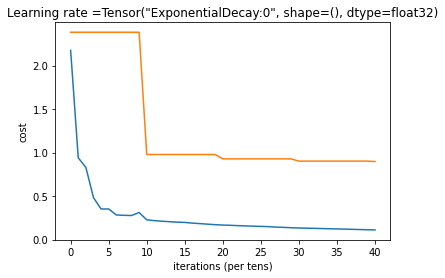

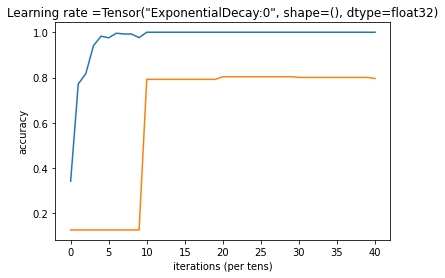

Parameters have been trained!


In [ ]:
parameters, val_acc, features, x, y, confusion = train_mynetwork(Train_X, Test_X, X_train, X_test, TrLabel, TeLabel, Train_L, Test_L)
sio.savemat('features.mat', {'features': features})

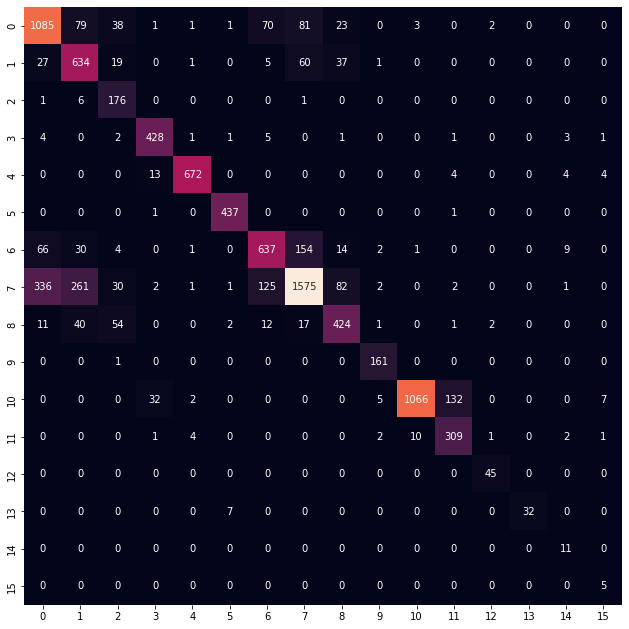

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (11,11))
sn.heatmap(confusion, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y, x)

0.7684312433786025

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
print(classification_report(y, x, target_names=target_names, digits=4))

              precision    recall  f1-score   support

           1     0.7092    0.7840    0.7447      1384
           2     0.6038    0.8087    0.6914       784
           3     0.5432    0.9565    0.6929       184
           4     0.8954    0.9575    0.9254       447
           5     0.9839    0.9641    0.9739       697
           6     0.9733    0.9954    0.9842       439
           7     0.7459    0.6939    0.7190       918
           8     0.8342    0.6514    0.7315      2418
           9     0.7298    0.7518    0.7406       564
          10     0.9253    0.9938    0.9583       162
          11     0.9870    0.8569    0.9174      1244
          12     0.6867    0.9364    0.7923       330
          13     0.9000    1.0000    0.9474        45
          14     1.0000    0.8205    0.9014        39
          15     0.3667    1.0000    0.5366        11
          16     0.2778    1.0000    0.4348         5

    accuracy                         0.7959      9671
   macro avg     0.7601   

In [ ]:
from sklearn.metrics import classification_report
target_names = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']
c_p = (classification_report(y, x, target_names=target_names, digits=4, output_dict=True))
r = np.zeros(17)
for key in range(1,17):
  c = str(key)
  r[key] = round((c_p[c]['recall']),4)
print("Average accuracy:",round((sum(r)/16),4))

Average accuracy: 0.8857
